In [7]:
import numpy as np 
from sklearn.manifold import TSNE as t_sne
from sklearn.datasets import make_swiss_roll 
from sklearn.manifold import LocallyLinearEmbedding as lle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D
%matplotlib inline 

from ipywidgets import *
import pickle
import time

import plot_functions as PL
import helpers as HL

%load_ext autoreload

%autoreload 2

# Section III B-1: Applying the Algorithms, LLE

In this section, an ordinary Swiss roll with 1000 data points and noise set to 0.01 is used. The effect of the  hyperparameters for LLE are explored. 

## Importing and plotting the data set: 

In [87]:
import pickle
create=True
if create: 
    X, lle_color, X_2d_lle=HL.make_swissroll(n=1000, noise=0.5)
    pickle.dump( X, open("Pickles/X_lle.pkl", "wb")) 
    pickle.dump( lle_color, open("Pickles/color_lle.pkl", "wb")) 
    pickle.dump( X_2d_lle, open("Pickles/X_2d_lle.pkl", "wb")) 
else: 
    lle_color=pickle.load(open("Pickles/color_lle.pkl", "rb"))
    X=pickle.load(open("Pickles/X_lle.pkl", "rb"))
    X_2d_lle=pickle.load(open("Pickles/X_2d_lle.pkl", "rb"))
    

In [88]:
print(np.squeeze(X_2d_lle).shape)

(2, 1000)


<IPython.core.display.Javascript object>


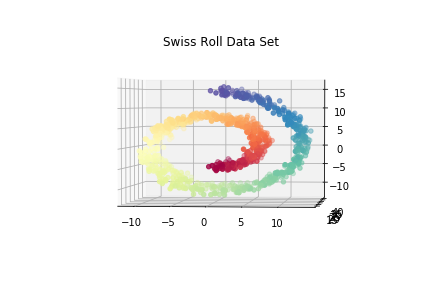

In [89]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=lle_color, cmap=plt.cm.Spectral)
ax.set_title("Swiss Roll Data Set")
plt.savefig('dataset.pdf')
plt.show()

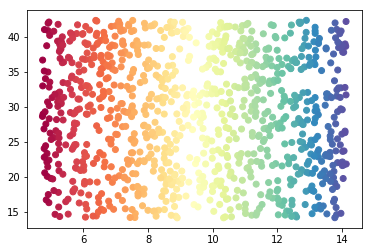

In [91]:
%matplotlib inline
HL.plot_2d(X_2d_lle,lle_color)

## Applying LLE

We want to apply the LLE algorithm, and play around with the hyperparameters.

# Analysing the effect of number of nearest neighbours

In [92]:

n_neighbors=np.arange(3,60,1)
n_components=2

create=True
if create: 
    n_Y=[]
    n_times=np.zeros(len(n_neighbors))
    n_reconstruction_error=np.zeros(len(n_neighbors))
    for i, n in enumerate(n_neighbors):
        # default reg=0.001
        LLE=lle(n,n_components,reg=0.0008,eigen_solver='auto')
        start_time=time.time()
        n_Y.append(LLE.fit_transform(X))
        n_times[i]= time.time()-start_time
        n_reconstruction_error[i]=LLE.reconstruction_error_ 
    pickle.dump( n_Y, open("Pickles/n_Y_lle.pkl", "wb")) 
    #pickle.dump(lle_color, open("lle_color.pkl","wb"))
    pickle.dump(n_neighbors, open("Pickles/n_neighbors.pkl","wb"))
    pickle.dump(n_times, open("Pickles/n_times.pkl","wb"))
    pickle.dump(n_reconstruction_error, open("Pickles/n_reconstruction_error.pkl","wb"))
else: 
    n_Y= pickle.load(open("Pickles/n_Y_lle.pkl", "rb"))
    #lle_color=pickle.load(open("lle_color.pkl", "rb"))
    n_neighbors=pickle.load(open("Pickles/n_neighbors.pkl", "rb"))
    n_times=pickle.load(open("Pickles/n_times.pkl", "rb"))
    n_reconstruction_error=pickle.load(open("Pickles/n_reconstruction_error.pkl", "rb"))
n_differences=HL.get_differences(X_2d_lle,n_Y)

In [93]:
## HÅVARD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler


    
def calculate_kmeans_metric(X_2d_orig, list_of_2d_manifolds, nb_clusters=2):
    # Calculate dist_matrix in original 2d_space
    orig_dist_mat = euclidean_distances(np.squeeze(X_2d_orig).T, np.squeeze(X_2d_orig).T)
    
    kmeans_metric_array = list()
    # loop through every 2d-transformation
    for manifold in list_of_2d_manifolds:
        kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, random_state=0).fit(manifold)
        
        kmeans_metric = 0
        # loop through every cluster
        for label in range(nb_clusters):
            #Get assignments from kmeans in 2d_ after algorithm
            boolean_label = kmeans.labels_==label
            cum_sum = 0
            # calculate distances to other datapoints in the same cluster
            for index, row in enumerate(orig_dist_mat):
                if boolean_label[index] == 1:
                    cum_sum += np.sum(row[boolean_label])
            kmeans_metric += cum_sum
            #print("cluster ",label)
            #print("nb_labels:", sum(kmeans.labels_==label))
            #print("sum", cum_sum)
        #print("\nKmeans model total:", kmeans_metric)
        kmeans_metric_array.append(kmeans_metric)
    return np.array(kmeans_metric_array)

# create kmeans metrics
kmeans_metrics_low = calculate_kmeans_metric(X_2d_lle, n_Y, nb_clusters=2)
kmeans_metrics_mid = calculate_kmeans_metric(X_2d_lle, n_Y, nb_clusters=4)
kmeans_metrics_high = calculate_kmeans_metric(X_2d_lle, n_Y, nb_clusters=6)

In [94]:
#scale metrics
scaler = StandardScaler(copy=True)

n_reconstruction_error = scaler.fit(n_reconstruction_error.reshape(-1, 1)).transform(n_reconstruction_error.reshape(-1, 1))
n_differences = scaler.fit(n_differences.reshape(-1, 1)).transform(n_differences.reshape(-1, 1))
kmeans_metrics_low = scaler.fit(kmeans_metrics_low.reshape(-1, 1)).transform(kmeans_metrics_low.reshape(-1, 1))
kmeans_metrics_mid = scaler.fit(kmeans_metrics_mid.reshape(-1, 1)).transform(kmeans_metrics_mid.reshape(-1, 1))
kmeans_metrics_high = scaler.fit(kmeans_metrics_high.reshape(-1, 1)).transform(kmeans_metrics_high.reshape(-1, 1))
n_times = scaler.fit(n_times.reshape(-1, 1)).transform(n_times.reshape(-1, 1))

# set weights
w_recon   = 0.4
w_diff    = 0.2
w_km_low  = 0.1
w_km_mid  = 0.1
w_km_high = 0.1
w_times   = 0.4

# calculate weighted linear combination of scores
combi_score = (w_recon*n_reconstruction_error + w_diff*n_differences + w_km_low*kmeans_metrics_low +
               w_km_mid*kmeans_metrics_mid + w_km_high*kmeans_metrics_high + w_times*n_times)


In [95]:
interactive(PL.plot_inter, Z=fixed(n_Y), color=fixed(lle_color),var=fixed(n_neighbors),variable=fixed('n_neighbors'),
            transformation=fixed('LLE'),i=widgets.IntSlider(min=0,max=len(n_neighbors)-1,step=1, value=0),
           error=fixed(n_reconstruction_error),times=fixed(combi_score),difference=fixed(kmeans_metrics_high)
           ,error_type=fixed('reconstruction error'))




A Jupyter Widget

# Analysing the effect of reg

/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0206965761218364e-60 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0207477919056876e-80 / 1.1102230246251565e-16
  RuntimeWarning)
/Users/havardbjornoy/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0205439299004055e-100 / 1.1102230246251565e-16
  RuntimeWarning)


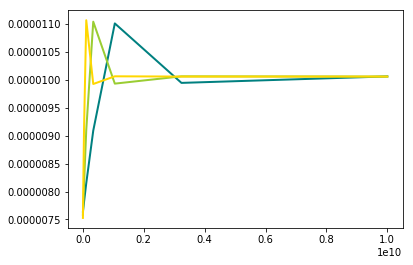

In [8]:

reg=np.logspace(-14,10,50) 
n_components=2
neighbors=12
create=True
if create: 
    r_Y=[]
    r_times=np.zeros(len(reg))
    r_reconstruction_error=np.zeros(len(reg))
   
    for i, r in enumerate(reg):
        LLE=lle(neighbors, n_components,reg=r,eigen_solver='auto')
        start_time=time.time()
        r_Y.append(LLE.fit_transform(X))
        r_times[i]= time.time()-start_time
        r_reconstruction_error[i]=LLE.reconstruction_error_ 
    pickle.dump( r_Y, open("Pickles/r_Y_lle.pkl", "wb")) 
    #pickle.dump(lle_color, open("lle_color.pkl","wb"))
    pickle.dump(reg, open("Pickles/reg.pkl","wb"))
    pickle.dump(r_times, open("Pickles/r_times.pkl","wb"))
    pickle.dump(r_reconstruction_error, open("Pickles/r_reconstruction_error.pkl","wb"))
    
    # HÅVARD prøver seg på metrics
    """
    from sklearn.linear_model import Ridge
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    
    # prøve å direkte regne ut en form for differanse
    r_reconstruction_acceleration = np.zeros(len(reg))
    for i, r in enumerate(r_reconstruction_error):
        if i != 0 and i != len(r_reconstruction_error)-1:
            r_reconstruction_acceleration[i] = min(((r_reconstruction_error[i+1] - r_reconstruction_error[i])),100) # (C-B)/(B-A)
        else:
            r_reconstruction_acceleration[i] = 0
    
    # prøve å gjøre en polynomisk regression
    X = np.copy(reg[:, np.newaxis])
    colors = ['teal', 'yellowgreen', 'gold']
    
    for count, degree in enumerate([3,4,5]):
        model = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(X, r_reconstruction_error)
        y_plot = model.predict(X)
        plt.plot(X, y_plot, color=colors[count], linewidth=2,
                 label="degree %d" % degree)
    """
    
    
else: 
    r_Y= pickle.load(open("Pickles/r_Y_lle.pkl", "rb"))
    #lle_color=pickle.load(open("lle_color.pkl", "rb"))
    reg=pickle.load(open("Pickles/reg.pkl", "rb"))
    r_times=pickle.load(open("Pickles/r_times.pkl", "rb"))
    r_reconstruction_error=pickle.load(open("Pickles/r_reconstruction_error.pkl", "rb"))
r_differences=HL.get_differences(X_2d_lle,r_Y)

In [9]:
interactive(PL.plot_inter, Z=fixed(r_Y), color=fixed(lle_color),var=fixed(reg),variable=fixed('reg'), 
            transformation=fixed('LLE'),i=widgets.IntSlider(min=0,max=len(reg)-1,step=1, value=0),
           error=fixed(r_reconstruction_error),times=fixed(r_reconstruction_acceleration),difference=fixed(r_differences)
           ,error_type=fixed('reconstruction error'))



A Jupyter Widget

In [ ]:
print(len(reg))

# Analysing the effect of 